### 导入相应库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,Lasso,ElasticNet  #线性回归
from sklearn.ensemble import RandomForestRegressor #随机森林回归
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR  #支持向量回归
import lightgbm as lgb #lightGbm模型
from xgboost import XGBRFRegressor

from sklearn.model_selection import train_test_split # 切分数据
from sklearn.metrics import mean_squared_error #评价指标
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### 加载数据

#### 特征工程（未降维数据）

In [2]:
all_data = pd.read_csv('./processed_zhengqi_data2.csv')

# 训练数据
cond = all_data['label'] == 'train'
train_data = all_data[cond]
train_data.drop(labels = 'label',axis = 1,inplace = True)

# 从训练数据中提取特征数据X和目标值y
X = train_data.drop(labels='target',axis = 1)
y = train_data['target']

# 切分数据 训练数据80% 验证数据20%
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2)

# 测试提交数据
cond2 = all_data['label'] == 'test'
submit_test = all_data[cond2]
submit_test.drop(labels = ['label','target'],axis = 1,inplace = True)

#### 特征工程（降维数据）

In [3]:
#采用 pca 保留特征的数据
X_pca = np.load('./train_data_pca.npz')['X_train']
y_pca = np.load('./train_data_pca.npz')['y_train']

# 切分数据 训练数据80% 验证数据20%
X_train_pca,X_valid_pca,y_train_pca,y_valid_pca=train_test_split(X_pca,y_pca,
                                                               test_size=0.2)
submit_test_pca = np.load('./test_data_pca.npz')['X_test']

### 网格搜索GridSearchCV算法调参

In [4]:
def train_model(model, param_grid=[], X=[], y=[],splits=5, repeats=5):
    
    # 创建网格交叉
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # 设置网格搜索参数
    gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                           scoring='neg_mean_squared_error',# mean_squared_error
                           verbose=1, return_train_score=True)

    # 网格搜索训练
    gsearch.fit(X,y)

    # 提取最优算法
    model = gsearch.best_estimator_        

    # 获得最优算法平均得分和标准差
    best_idx = gsearch.best_index_ # 最优算法索引
    grid_results = pd.DataFrame(gsearch.cv_results_)       
    cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
    cv_std = grid_results.loc[best_idx,'std_test_score']
    
    # 平均值和方差数据合并
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # 预测
    y_pred = model.predict(X)
    
    # 输出模型评价指标
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('mse=',mean_squared_error(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # 残差数据可视化
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid # 残差标准化Z-score
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    
    ax2=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax3=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax3)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

### 非降维数据

In [12]:
# 可选模型
opt_models = dict()
# 记录模型表现
score_models = pd.DataFrame(columns=['mean','std'])

splits = 5
repeats = 5

#### 岭回归

Fitting 25 folds for each of 25 candidates, totalling 625 fits
----------------------
Ridge(alpha=0.1)
----------------------
score= 0.8902000535130349
mse= 0.10092360225245812
cross_val: mean= 0.10336376761792092 , std= 0.005363070368960136
Wall time: 4.14 s


Text(0, 0.5, 'mse')

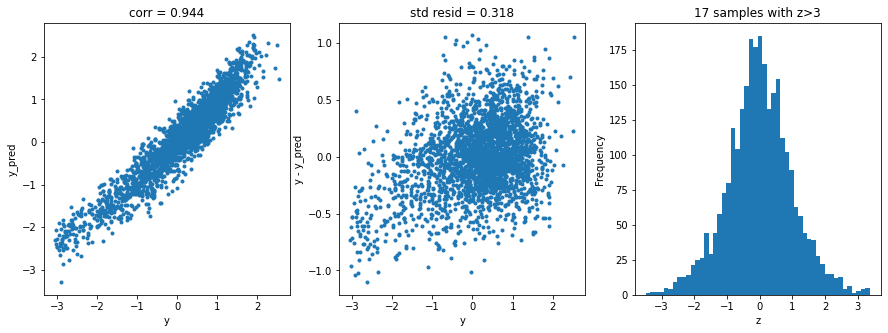

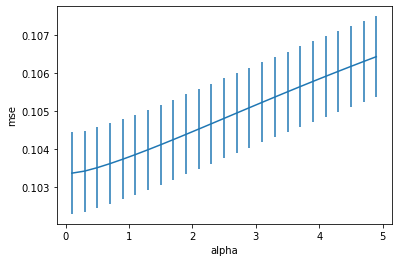

In [13]:
%%time
model = 'Ridge'
opt_models[model] = Ridge()

alphas = np.arange(0.1,5,0.2)
param_grid = {'alpha': alphas}

opt_models[model],cv_score,grid_results = train_model(opt_models[model],
                                                      param_grid=param_grid,
                                                      X = X,y = y,
                                                      splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alphas, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('mse')

In [9]:
alphas.shape

(25,)

In [14]:
score_models

,mean,std
Ridge,0.103364,0.005363


In [11]:
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,mean_train_score,std_train_score
0,0.002794,0.000924,0.001902,0.000561,0.1,{'alpha': 0.1},-0.103418,-0.100751,-0.113837,-0.099943,...,-0.100655,-0.103235,-0.099517,-0.098057,-0.101391,-0.100604,-0.101220,-0.101761,-0.100650,0.001332
1,0.002334,0.000727,0.001909,0.000624,0.3,{'alpha': 0.30000000000000004},-0.103736,-0.100507,-0.113789,-0.100193,...,-0.100735,-0.103320,-0.099628,-0.098172,-0.101473,-0.100691,-0.101319,-0.101874,-0.100748,0.001332
2,0.002360,0.000628,0.001965,0.000654,0.5,{'alpha': 0.5000000000000001},-0.104002,-0.100339,-0.113802,-0.100449,...,-0.100838,-0.103429,-0.099765,-0.098313,-0.101583,-0.100800,-0.101446,-0.102008,-0.100872,0.001333
3,0.002114,0.000862,0.002104,0.000715,0.7,{'alpha': 0.7000000000000001},-0.104243,-0.100212,-0.113844,-0.100702,...,-0.100950,-0.103549,-0.099911,-0.098463,-0.101707,-0.100919,-0.101585,-0.102145,-0.101005,0.001333
4,0.002467,0.000676,0.001929,0.000667,0.9,{'alpha': 0.9000000000000001},-0.104472,-0.100113,-0.113905,-0.100950,...,-0.101068,-0.103674,-0.100061,-0.098617,-0.101841,-0.101044,-0.101731,-0.102283,-0.101144,0.001334
5,0.002281,0.000530,0.001966,0.000532,1.1,{'alpha': 1.1000000000000003},-0.104695,-0.100036,-0.113979,-0.101194,...,-0.101191,-0.103804,-0.100214,-0.098774,-0.101981,-0.101174,-0.101883,-0.102420,-0.101287,0.001334
6,0.002476,0.000805,0.001834,0.000436,1.3,{'alpha': 1.3000000000000003},-0.104914,-0.099979,-0.114064,-0.101434,...,-0.101317,-0.103938,-0.100370,-0.098933,-0.102128,-0.101308,-0.102039,-0.102558,-0.101433,0.001335
7,0.002282,0.000772,0.001912,0.000846,1.5,{'alpha': 1.5000000000000004},-0.105131,-0.099937,-0.114157,-0.101671,...,-0.101446,-0.104074,-0.100527,-0.099094,-0.102279,-0.101445,-0.102199,-0.102695,-0.101581,0.001336
8,0.002401,0.000543,0.001878,0.000843,1.7,{'alpha': 1.7000000000000004},-0.105347,-0.099910,-0.114256,-0.101904,...,-0.101578,-0.104213,-0.100686,-0.099255,-0.102433,-0.101584,-0.102360,-0.102832,-0.101731,0.001337
9,0.002089,0.000645,0.001805,0.000645,1.9,{'alpha': 1.9000000000000004},-0.105560,-0.099894,-0.114361,-0.102134,...,-0.101711,-0.104353,-0.100846,-0.099417,-0.102590,-0.101725,-0.102523,-0.102969,-0.101882,0.001338


#### 套索回归

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Lasso(alpha=0.0001)
----------------------
score= 0.8901155559523605
mse= 0.10100126894062737
cross_val: mean= 0.10377223089437403 , std= 0.004806415049746983
Wall time: 10.6 s


Text(0, 0.5, 'mse')

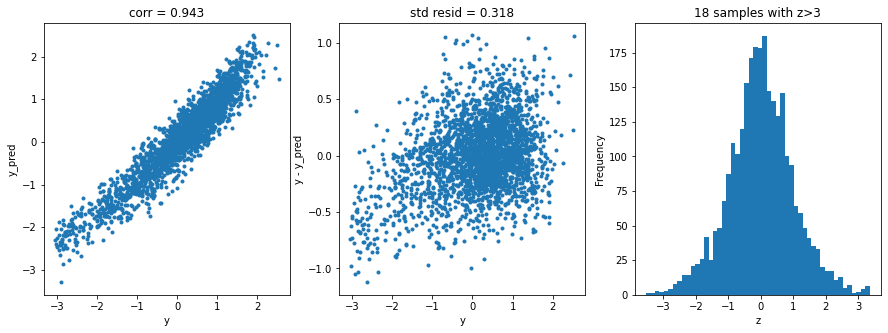

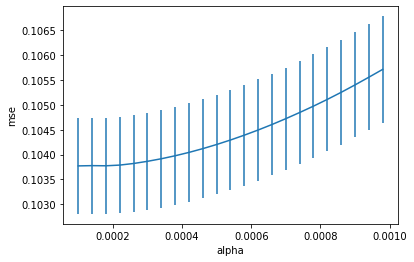

In [15]:
%%time
model = 'Lasso'

opt_models[model] = Lasso()
alphas = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alphas}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alphas, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('mse')

In [17]:
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'split10_test_score',
       'split11_test_score', 'split12_test_score', 'split13_test_score',
       'split14_test_score', 'split15_test_score', 'split16_test_score',
       'split17_test_score', 'split18_test_score', 'split19_test_score',
       'split20_test_score', 'split21_test_score', 'split22_test_score',
       'split23_test_score', 'split24_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'split5_train_score', 'split6_train_score',
       'split7_train_score', 'split8_train_score', 'split9_train

#### 弹性网络

Fitting 25 folds for each of 81 candidates, totalling 2025 fits
----------------------
ElasticNet(alpha=0.0001, l1_ratio=0.30000000000000004, max_iter=10000)
----------------------
score= 0.8901312137886744
mse= 0.10098687690042292
cross_val: mean= 0.1037081857011029 , std= 0.0075442721802750036


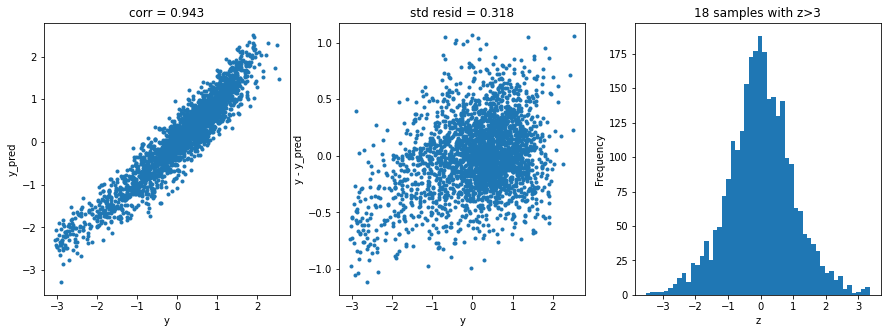

In [18]:
model ='ElasticNet'
opt_models[model] = ElasticNet(max_iter=10000)

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

In [19]:
np.arange(0.1,1.0,0.1).shape

(9,)

In [20]:
np.arange(1e-4,1e-3,1e-4).shape

(9,)

#### SVR

Fitting 25 folds for each of 5 candidates, totalling 125 fits
----------------------
SVR(C=0.9000000000000001)
----------------------
score= 0.7295322521443957
mse= 0.24860284799808752
cross_val: mean= 0.24932472306396555 , std= 0.010996974167330562
Wall time: 1min 7s


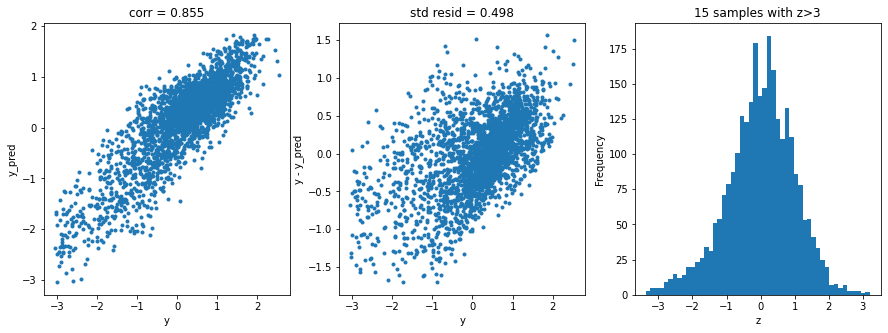

In [21]:
%%time
model='SVR'
opt_models[model] = SVR()

param_grid = {'C':np.arange(0.1,1.0,0.2)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=repeats)


cv_score.name = model
score_models = score_models.append(cv_score)

#### GBDT

Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------
GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=200)
----------------------
score= 0.9881571826018469
mse= 0.01088543146768819
cross_val: mean= 0.08976167618394948 , std= 0.0022245830289117693
Wall time: 6min 54s


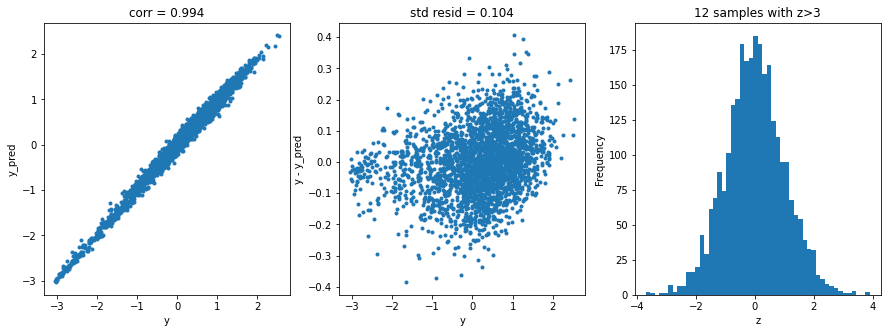

In [22]:
%%time
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[100,200,300],
              'max_depth':[3,5,7],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

#### 随机森林

Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------------------
RandomForestRegressor(max_features=16, min_samples_split=5, n_estimators=200)
----------------------
score= 0.9818017045248687
mse= 0.01672712595012877
cross_val: mean= 0.09554611688004881 , std= 0.006548665559568625
Wall time: 7min 53s


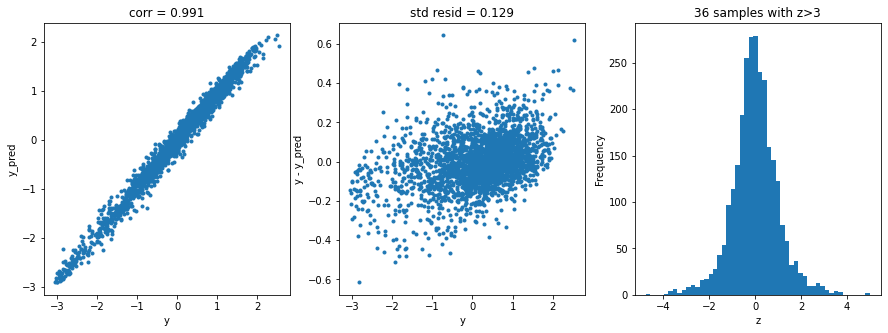

In [23]:
%%time
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,200,300],
              'max_features':[12,16,20,24],
              'min_samples_split':[5,7,9]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

#### Xgboost

Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------------------
XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=300, n_jobs=16,
               num_parallel_tree=300, objective='reg:squarederror',
               predictor='auto', random_state=0, reg_alpha=0,
               reg_lambda=0.00021, scale_pos_weight=1, tree_method='exact',
               validate_parameters=1, verbosity=None)
----------------------
score= 0.9003007450187164
mse= 0.09163946137070277
cross_val: mean= 0.1164286657351558 , std= 0.005785578696726894
Wall time: 1min 31s


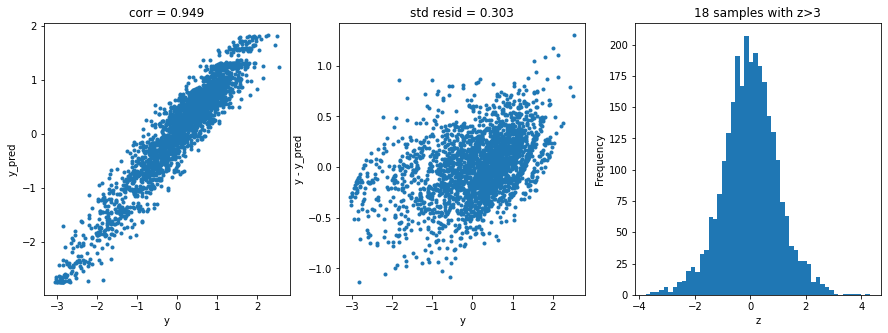

In [24]:
%%time
model = 'XGB'
opt_models[model] = XGBRFRegressor()

param_grid = {'n_estimators':[200,300],
              'max_depth':[3,5],
              'reg_lambda': np.arange(1e-5,1e-3,1e-4)}

opt_models[model], cv_score,grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

#### lightGBM

Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------------------
LGBMRegressor(max_depth=5, min_child_weight=3, n_estimators=200, reg_alpha=0.01,
              reg_lambda=0.01)
----------------------
score= 0.9791955891359189
mse= 0.019122560204457892
cross_val: mean= 0.08946762026703706 , std= 0.004600778509210142
Wall time: 2min 17s


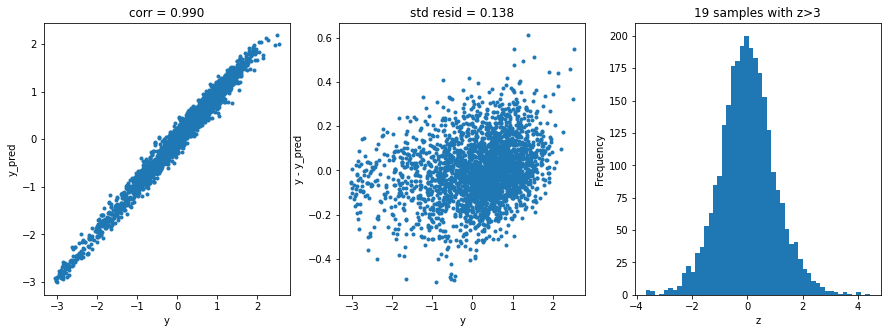

In [25]:
%%time
model = 'lightGBM'
opt_models[model] = lgb.LGBMRegressor()

param_grid = {'n_estimators':[200,300],
              'max_depth':[3,5],
              'min_child_weight': range(3, 6, 1),
              'reg_alpha': [1e-5, 1e-2, 0.1, 1],
              'reg_lambda': [1e-5, 1e-2, 0.1, 1]}

opt_models[model], cv_score,grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        X = X,y = y,
                                                        splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

In [26]:
score_models

,mean,std
Ridge,0.103364,0.005363
Lasso,0.103772,0.004806
ElasticNet,0.103708,0.007544
SVR,0.249325,0.010997
GradientBoosting,0.089762,0.002225
RandomForest,0.095546,0.006549
XGB,0.116429,0.005786
lightGBM,0.089468,0.004601


In [27]:
opt_models

{'Ridge': Ridge(alpha=0.1),
 'Lasso': Lasso(alpha=0.0001),
 'ElasticNet': ElasticNet(alpha=0.0001, l1_ratio=0.30000000000000004, max_iter=10000),
 'SVR': SVR(C=0.9000000000000001),
 'GradientBoosting': GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=200),
 'RandomForest': RandomForestRegressor(max_features=16, min_samples_split=5, n_estimators=200),
 'XGB': XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=300, n_jobs=16,
                num_parallel_tree=300, objective='reg:squarederror',
                predictor='auto', random_state=0, reg_alpha=0,
                reg_lambda=0.00021, scale_pos_weight=1, tree_method='exact',
                validate_parameters=

### 模型预测-多模型bagging

In [28]:
def model_predict(submit_test):
    i=0
    y_predict_total = np.zeros(submit_test.shape[0])
    
    for model in opt_models.keys():
        y_predict = opt_models[model].predict(submit_test)
        
        y_predict_total += y_predict
        
        i+=1
    # 求平均
    y_predict_mean = np.round(y_predict_total/i,3)
    
    return y_predict_mean

In [29]:
result = model_predict(submit_test)

np.savetxt('./bagging_result.txt',result)

In [30]:
result

array([ 0.251,  0.217, -0.122, ..., -2.674, -2.69 , -2.513])